In [40]:
import pdb
import sys
import warnings

import numpy as np
import pandas as pd
import yaml
import matplotlib as mpl
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
sys.path.append('../../../bin')
import plots_FM_running as plot_utils

sys.path.append('../../../../common_lib_and_cfg/common_config')
import mpl_cfg

sys.path.append('../../../../common_lib_and_cfg/common_lib')
import my_module as mm

mpl.rcParams.update(mpl_cfg.mpl_rcParams_dict)

In [43]:
# ! options
specs_str = 'idMag0-idRSD0-idFS0-idSysWL3-idSysGC4'
nbl_WL_opt = 32
ep_or_ed = 'EP'
zbins = 10
num_base_cosmo_params = 7
fix_curvature = True
fix_gal_bias = False
fix_shear_bias = False  # this has to be an outer loop if you also want to vary the shear bias prior itself
fix_dz = True
include_fom = True
fid_shear_bias_prior = 1e-4
shear_bias_prior = None
gal_bias_perc_prior = None
shear_bias_priors = [1e-7, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e4, None]
gal_bias_perc_priors = shear_bias_priors
string_columns = ['probe', 'go_or_gs', 'fix_shear_bias', 'fix_gal_bias',
                  'shear_bias_prior', 'gal_bias_perc_prior']
triangle_plot = False
# ! options


go_or_gs_folder_dict = {
    'GO': 'GaussOnly',
    'GS': 'GaussSSC',
}
probes_vinc = ('WLO', 'GCO', '3x2pt')

In [44]:
fm_uncert_df = pd.DataFrame()
for go_or_gs in ['GO', 'GS']:
    for probe_vinc in probes_vinc:
        for fix_shear_bias in [True, False]:
            for fix_gal_bias in [True, False]:
                for shear_bias_prior in shear_bias_priors:
                    for gal_bias_perc_prior in gal_bias_perc_priors:

                        print(f'****** {probe_vinc}, {go_or_gs} ******')

                        names_params_to_fix = []

                        fm_path = f'/Users/davide/Documents/Lavoro/Programmi/common_data/vincenzo/SPV3_07_2022/Flagship_1_restored/' \
                                  f'FishMat_restored/{go_or_gs_folder_dict[go_or_gs]}/{probe_vinc}/FS1NoCuts'
                        fm_name = f'fm-{probe_vinc}-{nbl_WL_opt}-wzwaCDM-NonFlat-GR-TB-{specs_str}-{ep_or_ed}{zbins}'
                        fm = np.genfromtxt(f'{fm_path}/{fm_name}.dat')

                        with open('/Users/davide/Documents/Lavoro/Programmi/common_lib_and_cfg/common_config/'
                                  'fiducial_params_dict_for_FM.yml') as f:
                            fiducials_dict = yaml.safe_load(f)

                        assert len(fiducials_dict) == fm.shape[0] == fm.shape[1], 'Wrong shape of FM matrix!'

                        # fix some of the parameters (i.e., which columns to remove)
                        if fix_curvature:
                            print('fixing curvature')
                            names_params_to_fix += ['Om_Lambda0']
                            num_params_tokeep = num_base_cosmo_params
                        else:
                            num_params_tokeep = num_base_cosmo_params + 1

                        if fix_shear_bias:
                            print('fixing shear bias parameters')
                            names_params_to_fix += [f'm{(zi + 1):02d}_photo' for zi in range(zbins)]
                            # in this way 👇there is no need for a 'add_shear_bias_prior' (or similar) boolean flag
                            shear_bias_prior = None

                        if fix_gal_bias:
                            print('fixing galaxy bias parameters')
                            names_params_to_fix += [f'b{(zi + 1):02d}_photo' for zi in range(zbins)]
                            gal_bias_perc_prior = None

                        if fix_dz:
                            print('fixing dz parameters')
                            names_params_to_fix += [f'dz{(zi + 1):02d}_photo' for zi in range(zbins)]

                        fm, fiducials_dict = mm.mask_fm_v2(fm, fiducials_dict, names_params_to_fix,
                                                           remove_null_rows_cols=True)

                        param_names = list(fiducials_dict.keys())

                        # add prior on shear bias
                        if shear_bias_prior != None and probe_vinc != 'GCO':
                            shear_bias_param_names = [f'm{(zi + 1):02d}_photo' for zi in range(zbins)]
                            shear_bias_prior_values = np.array([shear_bias_prior] * zbins)
                            fm = mm.add_prior_to_fm(fm, fiducials_dict, shear_bias_param_names, shear_bias_prior_values)

                        # add prior on galaxy bias
                        if gal_bias_perc_prior != None and probe_vinc != 'WLO':
                            gal_bias_param_names = [f'b{(zi + 1):02d}_photo' for zi in range(zbins)]

                            # go from sigma_b / b_fid to sigma_b
                            gal_bias_idxs = [param_names.index(gal_bias_param_name)
                                             for gal_bias_param_name in gal_bias_param_names]

                            warnings.warn('update the fiducial values to FS1!!!!')
                            gal_bias_fid_values = np.array(list(fiducials_dict.values()))[gal_bias_idxs]
                            gal_bias_prior_values = gal_bias_perc_prior * gal_bias_fid_values / 100
                            fm = mm.add_prior_to_fm(fm, fiducials_dict, gal_bias_param_names, gal_bias_prior_values)

                        # ! triangle plot
                        if triangle_plot:
                            if probe_vinc == '3x2pt' and go_or_gs == 'GS' and fix_shear_bias == False:
                                # decide params to show in the triangle plot
                                cosmo_param_names = list(fiducials_dict.keys())[:num_params_tokeep]
                                shear_bias_param_names = [f'm{(zi + 1):02d}_photo' for zi in range(zbins)]
                                params_tot_list = cosmo_param_names + shear_bias_param_names

                                trimmed_fid_dict = {param: fiducials_dict[param] for param in params_tot_list}

                                # get the covariance matrix (careful on how you cut the FM!!)
                                fm_idxs_tokeep = [list(fiducials_dict.keys()).index(param) for param in params_tot_list]
                                cov = np.linalg.inv(fm)[fm_idxs_tokeep, :][:, fm_idxs_tokeep]

                                plot_utils.contour_plot_chainconsumer(cov, trimmed_fid_dict)

                        # ! compute uncertainties from fm
                        uncert_fm = mm.uncertainties_fm_v2(fm, fiducials_dict, which_uncertainty='marginal',
                                                           normalize=True,
                                                           percent_units=True)[:num_params_tokeep]

                        # compute the FoM
                        w0wa_idxs = param_names.index('w_0'), param_names.index('w_a')
                        fom = mm.compute_FoM(fm, w0wa_idxs)

                        df_columns_names = string_columns + [param_name for param_name in fiducials_dict.keys()][
                                                            :num_params_tokeep] + ['FoM']

                        # this is a list of lists just to have a 'row list' instead of a 'column list',
                        # I still haven't figured out the problem, but in this way it works
                        df_columns_values = [[probe_vinc, go_or_gs, fix_shear_bias, fix_gal_bias,
                                              shear_bias_prior, gal_bias_perc_prior] +
                                             uncert_fm.tolist() + [fom]]

                        assert len(df_columns_names) == len(df_columns_values[0]), 'Wrong number of columns!'

                        fm_uncert_df_to_concat = pd.DataFrame(df_columns_values, columns=df_columns_names)
                        fm_uncert_df = pd.concat([fm_uncert_df, fm_uncert_df_to_concat], ignore_index=True)

****** WLO, GO ******
fixing curvature
fixing shear bias parameters
fixing galaxy bias parameters
fixing dz parameters
****** WLO, GO ******
fixing curvature
fixing shear bias parameters
fixing galaxy bias parameters
fixing dz parameters
****** WLO, GO ******
fixing curvature
fixing shear bias parameters
fixing galaxy bias parameters
fixing dz parameters
****** WLO, GO ******
fixing curvature
fixing shear bias parameters
fixing galaxy bias parameters
fixing dz parameters
****** WLO, GO ******
fixing curvature
fixing shear bias parameters
fixing galaxy bias parameters
fixing dz parameters
****** WLO, GO ******
fixing curvature
fixing shear bias parameters
fixing galaxy bias parameters
fixing dz parameters
****** WLO, GO ******
fixing curvature
fixing shear bias parameters
fixing galaxy bias parameters
fixing dz parameters
****** WLO, GO ******
fixing curvature
fixing shear bias parameters
fixing galaxy bias parameters
fixing dz parameters
****** WLO, GO ******
fixing curvature
fixing sh

/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_90171/4063329330.py:65: UserWarning:

update the fiducial values to FS1!!!!



fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixing shear bias parameters
fixing dz parameters
****** GCO, GO ******
fixing curvature
fixi

Compute percent difference btw G and GS for each probe/nuisance value/parameter...

In [45]:
df_gs = fm_uncert_df[fm_uncert_df["go_or_gs"] == "GS"]
df_go = fm_uncert_df[fm_uncert_df["go_or_gs"] == "GO"]
arr_gs = df_gs.iloc[:, len(string_columns):].select_dtypes('number').values
arr_go = df_go.iloc[:, len(string_columns):].select_dtypes('number').values
perc_diff_df = df_gs
perc_diff_df.iloc[:, len(string_columns):] = (arr_gs / arr_go - 1) * 100
perc_diff_df['go_or_gs'] = 'perc_diff'
perc_diff_df.iloc[:, -1] = (arr_go[:, -1] / arr_gs[:, -1] - 1) * 100
fm_uncert_df = pd.concat([fm_uncert_df, perc_diff_df], axis=0, ignore_index=True)

/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_90171/226665789.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Select parameters to bar plot

In [46]:
probe_vinc_toplot = 'WLO'

fm_uncert_df_go_nuis_free = fm_uncert_df[(fm_uncert_df['go_or_gs'] == 'GO') &
                                        (fm_uncert_df['probe'] == probe_vinc_toplot) &
                                        (fm_uncert_df['fix_gal_bias'] == True) &  # this has no impact
                                        (fm_uncert_df['fix_shear_bias'] == True) 
                                        # (fm_uncert_df['shear_bias_prior'].isna())
                                        ]
# check that all the rows in the df are equal to the first one
assert all(fm_uncert_df_go_nuis_free.iloc[0] == fm_uncert_df_go_nuis_free.iloc[1])


AssertionError: 

In [51]:
fiducials_dict

{'Om_m0': 0.32,
 'Om_b0': 0.05,
 'w_0': -1.0,
 'w_a': 0.0,
 'h_0': 0.67,
 'n_s': 0.96,
 'sigma_8': 0.816,
 'A_IA': 1.72,
 'eta_IA': -0.41,
 'beta_IA': 2.17,
 'b01_photo': 1.0997727037892875,
 'b02_photo': 1.220245876862528,
 'b03_photo': 1.2723993083933989,
 'b04_photo': 1.316624471897739,
 'b05_photo': 1.35812370570578,
 'b06_photo': 1.3998214171814918,
 'b07_photo': 1.4446452851824907,
 'b08_photo': 1.4964959071110084,
 'b09_photo': 1.5652475842498528,
 'b10_photo': 1.7429859437184225,
 'm01_photo': 0.0,
 'm02_photo': 0.0,
 'm03_photo': 0.0,
 'm04_photo': 0.0,
 'm05_photo': 0.0,
 'm06_photo': 0.0,
 'm07_photo': 0.0,
 'm08_photo': 0.0,
 'm09_photo': 0.0,
 'm10_photo': 0.0}

In [ ]:
fm_uncert_df_go_nuis_free

,probe,go_or_gs,fix_shear_bias,fix_gal_bias,shear_bias_prior,gal_bias_perc_prior,Om_m0,Om_b0,w_0,w_a,h_0,n_s,sigma_8,A_IA,FoM,b01_photo
0,WLO,GO,True,True,NaN,NaN,5.909859,64.70156,24.263834,61.855137,29.349627,4.937515,2.359608,337.362681,17.052487,NaN
1,WLO,GO,True,True,NaN,NaN,5.909859,64.70156,24.263834,61.855137,29.349627,4.937515,2.359608,337.362681,17.052487,NaN
2,WLO,GO,True,True,NaN,NaN,5.909859,64.70156,24.263834,61.855137,29.349627,4.937515,2.359608,337.362681,17.052487,NaN
3,WLO,GO,True,True,NaN,NaN,5.909859,64.70156,24.263834,61.855137,29.349627,4.937515,2.359608,337.362681,17.052487,NaN
4,WLO,GO,True,True,NaN,NaN,5.909859,64.70156,24.263834,61.855137,29.349627,4.937515,2.359608,337.362681,17.052487,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,WLO,GO,True,True,NaN,NaN,5.909859,64.70156,24.263834,61.855137,29.349627,4.937515,2.359608,337.362681,17.052487,NaN
96,WLO,GO,True,True,NaN,NaN,5.909859,64.70156,24.263834,61.855137,29.349627,4.937515,2.359608,337.362681,17.052487,NaN
97,WLO,GO,True,True,NaN,NaN,5.909859,64.70156,24.263834,61.855137,29.349627,4.937515,2.359608,337.362681,17.052487,NaN
98,WLO,GO,True,True,NaN,NaN,5.909859,64.70156,24.263834,61.855137,29.349627,4.937515,2.359608,337.362681,17.052487,NaN


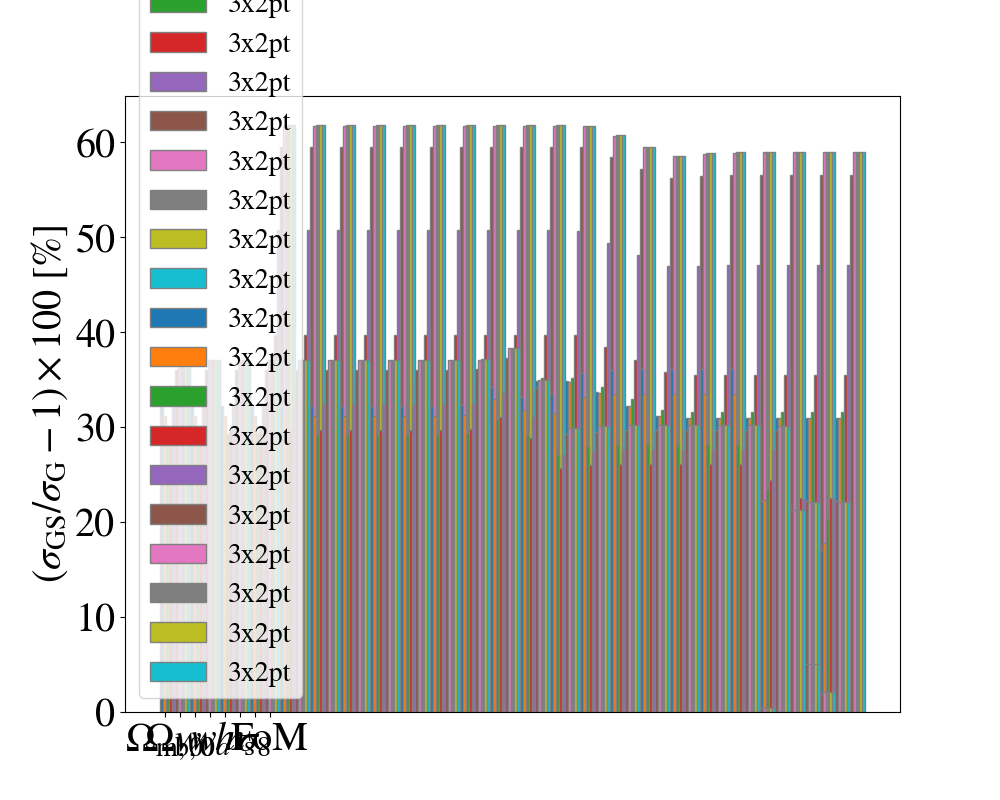

In [ ]:
# ! plot the uncertainties



ylabel = r'$(\sigma_{\rm GS}/\sigma_{\rm G} - 1) \times 100$ [%]'
data = fm_uncert_df_toplot.iloc[:, len(string_columns):].values
label_list = list(fm_uncert_df_toplot['probe'].values)
label_list = ['None' if value is None else value for value in label_list]
title = None

if include_fom:
    num_params_tokeep += 1
data = data[:, :num_params_tokeep]

plot_utils.bar_plot(data, title, label_list, bar_width=0.2, nparams=num_params_tokeep, param_names_label=None,
                    second_axis=False, no_second_axis_bars=0, superimpose_bars=False, show_markers=False, ylabel=ylabel,
                    include_fom=include_fom, figsize=(10, 8))

# plt.savefig('../output/plots/WL_vs_GC_vs_3x2pt_GOGS_perc_uncert_increase.pdf', bbox_inches='tight', dpi=600)

In [ ]:

# ! study FoM vs priors on shear and gal. bias
probe = 'GCO'
param_toplot = 'w_a'
other_nuisance_value = 1e-4  # for WLO and GCO this has no impact, of course
nuisance_name = 'gal_bias'

# horrible cases selector
if probe == 'GCO':
    nuisance_name = 'gal_bias'
    nuisance_prior_name = 'gal_bias_perc_prior'
    other_nuisance_name = 'shear_bias_prior'
    xlabel = nuisance_prior_name

elif probe == 'WLO':
    nuisance_name = 'shear_bias'
    nuisance_prior_name = 'shear_bias_prior'
    other_nuisance_name = 'gal_bias_perc_prior'
    xlabel = nuisance_prior_name

elif probe == '3x2pt':
    if nuisance_name == 'gal_bias':
        nuisance_prior_name = 'gal_bias_perc_prior'
        other_nuisance_name = 'shear_bias_prior'
    elif nuisance_name == 'shear_bias':
        nuisance_prior_name = 'shear_bias_prior'
        other_nuisance_name = 'gal_bias_perc_prior'
    xlabel = f'{nuisance_name} prior'
    xlabel += f'; {other_nuisance_name} = {other_nuisance_value}'

else:
    raise ValueError('Wrong probe!')

nuisance_vals = fm_uncert_df.loc[(fm_uncert_df['probe'] == probe) &
                                 (fm_uncert_df['go_or_gs'] == 'GO') &
                                 (fm_uncert_df[f'fix_{nuisance_name}'] == False) &
                                 (fm_uncert_df[other_nuisance_name] == other_nuisance_value)
                                 ][nuisance_prior_name].values
param_toplot_go = fm_uncert_df.loc[(fm_uncert_df['probe'] == probe) &
                                   (fm_uncert_df['go_or_gs'] == 'GO') &
                                   (fm_uncert_df[f'fix_{nuisance_name}'] == False) &
                                   (fm_uncert_df[other_nuisance_name] == other_nuisance_value)
                                   ][param_toplot].values
param_toplot_gs = fm_uncert_df.loc[(fm_uncert_df['probe'] == probe) &
                                   (fm_uncert_df['go_or_gs'] == 'GS') &
                                   (fm_uncert_df[f'fix_{nuisance_name}'] == False) &
                                   (fm_uncert_df[other_nuisance_name] == other_nuisance_value)
                                   ][param_toplot].values
param_toplot_perc_diff = fm_uncert_df.loc[(fm_uncert_df['probe'] == probe) &
                                          (fm_uncert_df['go_or_gs'] == 'perc_diff') &
                                          (fm_uncert_df[f'fix_{nuisance_name}'] == False) &
                                          (fm_uncert_df[other_nuisance_name] == other_nuisance_value)
                                          ][param_toplot].values

# these below are all horizontal lines
param_toplot_fix_nuisance_go = fm_uncert_df.loc[(fm_uncert_df['probe'] == probe) &
                                                (fm_uncert_df['go_or_gs'] == 'GO') &
                                                (fm_uncert_df[f'fix_{nuisance_name}'] == True) &
                                                (fm_uncert_df[other_nuisance_name] == other_nuisance_value)
                                                ][param_toplot].values
param_toplot_fix_nuisance_gs = fm_uncert_df.loc[(fm_uncert_df['probe'] == probe) &
                                                (fm_uncert_df['go_or_gs'] == 'GS') &
                                                (fm_uncert_df[f'fix_{nuisance_name}'] == True) &
                                                (fm_uncert_df[other_nuisance_name] == other_nuisance_value)
                                                ][param_toplot].values

fm_uncert_df_toplot_no_prior_go = fm_uncert_df.loc[(fm_uncert_df['probe'] == probe) &
                                                   (fm_uncert_df['go_or_gs'] == 'GO') &
                                                   (fm_uncert_df[f'fix_{nuisance_name}'] == False) &
                                                   (fm_uncert_df[other_nuisance_name] == other_nuisance_value) &
                                                   (fm_uncert_df[nuisance_prior_name].isna())
                                                   ][param_toplot].values
fm_uncert_df_toplot_no_prior_gs = fm_uncert_df.loc[(fm_uncert_df['probe'] == probe) &
                                                   (fm_uncert_df['go_or_gs'] == 'GS') &
                                                   (fm_uncert_df[f'fix_{nuisance_name}'] == False) &
                                                   (fm_uncert_df[other_nuisance_name] == other_nuisance_value) &
                                                   (fm_uncert_df[nuisance_prior_name].isna())
                                                   ][param_toplot].values

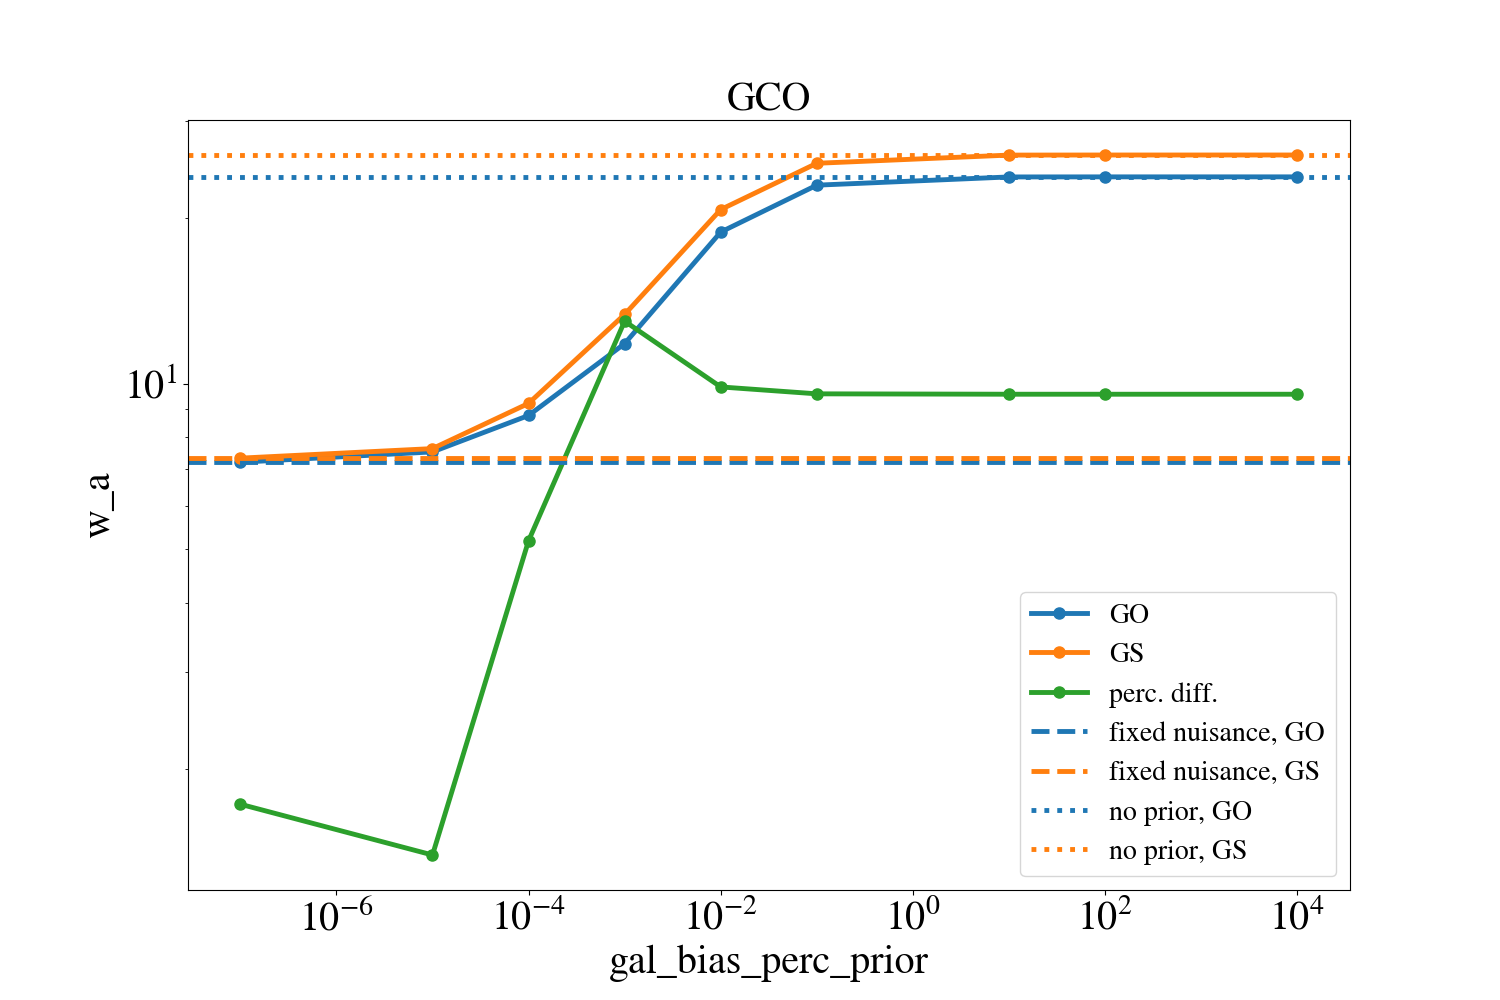

In [ ]:

plt.figure()
plt.plot(nuisance_vals, param_toplot_go, ls='-', marker='o', label='GO', color='tab:blue')
plt.plot(nuisance_vals, param_toplot_gs, ls='-', marker='o', label='GS', color='tab:orange')
plt.plot(nuisance_vals, param_toplot_perc_diff, ls='-', marker='o', label='perc. diff.', color='tab:green')
plt.axhline(param_toplot_fix_nuisance_go[0], ls='--', label='fixed nuisance, GO', color='tab:blue')
plt.axhline(param_toplot_fix_nuisance_gs[0], ls='--', label='fixed nuisance, GS', color='tab:orange')
plt.axhline(fm_uncert_df_toplot_no_prior_go[0], ls=':', label='no prior, GO', color='tab:blue')
plt.axhline(fm_uncert_df_toplot_no_prior_gs[0], ls=':', label='no prior, GS', color='tab:orange')
plt.xlabel(xlabel)
plt.ylabel(param_toplot)
plt.xscale('log')
plt.yscale('log')
plt.title(probe)
plt.legend()
